In [122]:
library(dplyr)
library(regclass)
library(olsrr)
library(car)
library(ggplot2)
library(mgcv)
library(plotly)
library(Metrics)

MyClass <- setRefClass("MyClass",
                       fields = list(
                         train_data = "data.frame",
                         test_data = "data.frame",
                         model = "lm"
                       ),
methods = list(

  replace_missing = function(data)
  {
    numeric_columns <- sapply(data, is.numeric)

    for (column_name in names(data)[numeric_columns])
    {
      median_value <- median(data[[column_name]], na.rm = TRUE)
      data[[column_name]][is.na(data[[column_name]])] <- median_value
    }
    return(data)
  },

  preparing_train_data = function()
  {
    train_data$Invoice <<- as.numeric(gsub("[$,]", "", train_data$Invoice))
    train_data$MSRP <<- as.numeric(gsub("[$,]", "", train_data$MSRP))
    train_data <<- replace_missing(train_data)
  },

  preparing_test_data = function()
  {
    test_data$Invoice <<- as.numeric(gsub("[$,]", "", test_data$Invoice))
    test_data$MSRP <<- as.numeric(gsub("[$,]", "", test_data$MSRP))
    test_data <<- replace_missing(test_data)
  },

  base_linear_model = function()
  {
    model <<- lm(MPG_City ~ Length + Weight + Wheelbase + Horsepower + Invoice + EngineSize + Cylinders + Origin + Type, data = train_data)
  },

  find_outliers = function(data)
  {
      n <- nrow(data)
      p <- length(coef(model))
      threshold <- 2 * sqrt(p / n)
      outliers <- which(abs(dffits(model)) > threshold)
      return (outliers)
  },

  delete_outliers_train_data = function()
  {
      outliers <- find_outliers(train_data)
      train_data <<- train_data[-outliers,]
  },

  merge_levels_train_data = function()
  {
    #suggest_levels(MPG_City ~ Type, data = train_data)
    train_data$Type[train_data$Type == "Sedan" | train_data$Type == "Wagon" ] <<- "Sedan_and_Wagon"
    train_data$Origin[train_data$Origin == "Europe" | train_data$Origin == "USA" ] <<- "Europe_and_USA"
    train_data$Origin <<- as.factor(train_data$Origin)
    train_data$Type <<- as.factor(train_data$Type)
  },

  merge_levels_test_data = function()
  {
    test_data$Type[test_data$Type == "Sedan" | test_data$Type == "Wagon" ] <<- "Sedan_and_Wagon"
    test_data$Origin[test_data$Origin == "Europe" | test_data$Origin == "USA" ] <<- "Europe_and_USA"
    test_data$Origin <<- as.factor(test_data$Origin)
    test_data$Type <<- as.factor(test_data$Type)
  },

  reg = function()
  {
    stepwise_reg <- ols_step_both_p(model)
    model <<- lm(formula(stepwise_reg$model), data = train_data)
  },

  plot = function(data)
  {
    # генерация сетки 20x20 для Weight и Horsepower
    weight <- seq(min(data$Weight), max(data$Weight), length.out = 20)
    horsepower <- seq(min(data$Horsepower), max(data$Horsepower), length.out = 20)

    invoice <- mean(data$Invoice)
    cylinders <- mean(data$Cylinders)
    wheelbase <- mean(data$Wheelbase)
    length <- mean(data$Length)
    typeSports <- sum(data$Type == "Sports") / nrow(data)
    typeSUV <- sum(data$Type == "SUV") / nrow(data)
    typeTruck <- sum(data$Type == "Truck") / nrow(data)
    originEurope_and_USA <- sum(data$Origin == "Europe_and_USA") / nrow(data)
    coefficients <- coef(model)
    # генерация матрицы значений отклика
    z <- outer(weight, horsepower, function(weight, horsepower)
    {coefficients["Weight"]*weight + coefficients["Horsepower"]*horsepower + typeSports*coefficients["TypeSports"] + typeSUV*coefficients["TypeSUV"] + originEurope_and_USA*coefficients["OriginEurope_and_USA"] + coefficients["Length"]*length + coefficients["Invoice"]*invoice + coefficients["Wheelbase"]*wheelbase + coefficients["Cylinders"] * cylinders + typeTruck*coefficients["TypeTruck"] + coefficients["(Intercept)"]})
    filled.contour(weight, horsepower, z, main = "Зависимость отклика от наиболее значимых предикторов", xlab = "Weight", ylab = "Horsepower")
  },

  print_metrics = function()
  {
    cat("Значение AIC модели:", AIC(model), '\n')
    cat("Значение BIC модели:", BIC(model), '\n')
    cat("R^2 модели:", summary(model)$r.squared, '\n')
  },

  fit = function(data)
  {
    train_data <<- data

    preparing_train_data()
    base_linear_model()
    delete_outliers_train_data()
    merge_levels_train_data()
    reg()
  },

  predict = function(model, data)
  {
    test_data <<- data

    preparing_test_data()
    merge_levels_test_data()

    y_pred <- model$coefficients[1] +
    (test_data$Weight * model$coefficients[2]) +
    ((ifelse(test_data$Type == "Sports", 1, 0))* model$coefficients[3]) +
    ((ifelse(test_data$Type == "SUV", 1, 0))* model$coefficients[4]) +
    ((ifelse(test_data$Type == "Truck", 1, 0))* model$coefficients[5]) +
    (test_data$Horsepower * model$coefficients[6]) +
    (test_data$Cylinders * model$coefficients[7]) +
    (test_data$Invoice * model$coefficients[8]) +
    ((ifelse(test_data$Origin == "Europe_and_USA", 1, 0))* model$coefficients[9]) +
    (test_data$Length * model$coefficients[10]) +
    (test_data$Wheelbase * model$coefficients[11])

    mape <- mape(y_pred, test_data$MPG_City)
    cat("Результирующее MAPE: ", mape, '\n')

    return(y_pred)
  }
)
)

Значение AIC модели: 1561.376 
Значение BIC модели: 1609.363 
R^2 модели: 0.8198729 


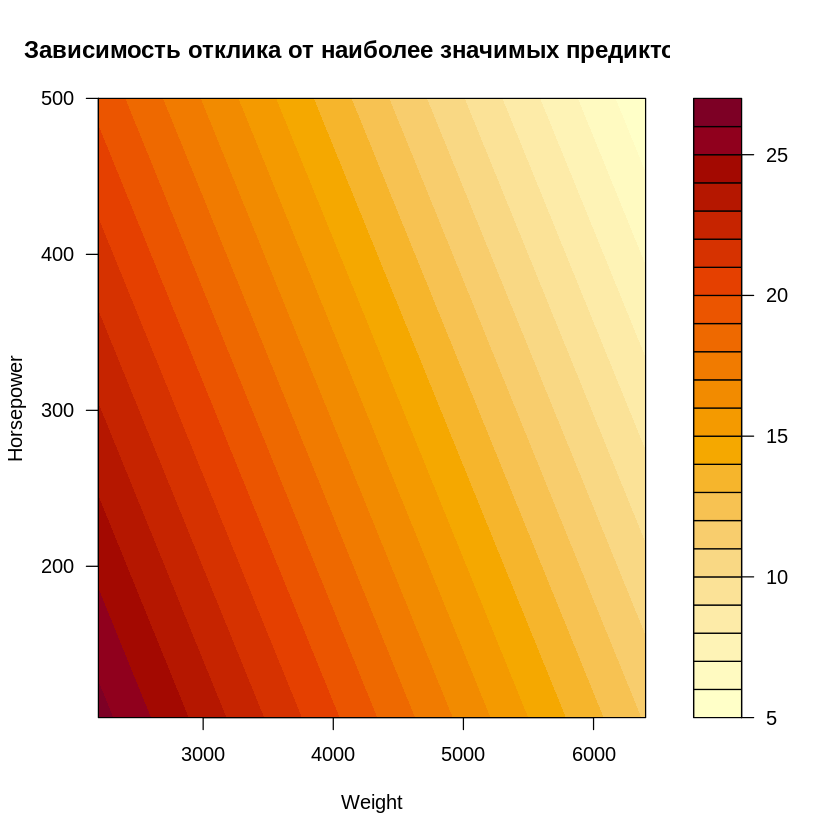

In [123]:
df <- read.csv('CARS.csv')
obj <- MyClass$new()
obj$fit(df)
obj$print_metrics()
obj$plot(obj$train_data)

In [127]:
test_data <- read.csv('test.csv')
model <- obj$model
obj$predict(model, test_data)

In [113]:
# install.packages('car')
# install.packages('ggplot2')
# install.packages('mgcv')
# install.packages('plotly')
# install.packages('olsrr')
# install.packages('regclass')
# install.packages('dplyr')
# install.packages('forecast')
# install.packages('Metrics')